# MLB Hall of Fame Data Analysis and Machine Learning

The following notebook contains some simple data analysis and machine learning using the __Baseball Databank__ dataset of MLB players (acquired from http://www.seanlahman.com/baseball-archive/statistics/). Two dataframes from the dataset were used for this project: the __Hall of Fame__ dataframe, which contains information about each player to appear on a hall of fame ballot, such as the year(s) they were on the ballot, and whether they got in; and the __Batting__ dataframe, which contains season-by-season hitting stats for every player to bat in the MLB. Some condensing and preprocessing was performed on the dataset to optimize it for this analysis.

For the purposes of this project, the following preprocessing actions were performed on the data:
* Only players to appear on a hall of fame ballot were selected from the Batting dataframe (min 500 PA to isolate hitters); this was done by merging the hall of fame dataframe to the batting dataframe on the _playerID_ column
* The dataset originally contained season-by-season stats; these were added together for each player such that it now contains players' career totals
* To reduce complexity, only the following stats were selected: __games played__, __at bats__, __hits__, and __home runs__; at bats and hits were used to calculate __batting average__, which was added as a new column
* Finally, the players' hall of fame status (inducted/not inducted) was converted to binary (1/0); this column was then added to the final _hof_batting_ dataframe to be used as our dependent variable of interest

Goals of this project were:
* Clean and preprocess data for analysis; 
* Run a linear regression of career stats on hall of fame induction status to see which variables contribute most to induction; 
* Create and refine a decision tree model which can predict whether a player will enter the hall given their stats

The project concludes with a test of the Decision Tree model in which it is given career stats of players who appear on the hall of fame ballot in 2021.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

hof_batting = pd.read_csv('hof_batting.csv')
hof_batting = hof_batting[(hof_batting.playerID != 'bondsba01') & (hof_batting.playerID != 'rosepe01')]

got_in = hof_batting[hof_batting.inductedbin == 1]
didnt_get_in = hof_batting[hof_batting.inductedbin == 0]
print(len(got_in))
print(len(didnt_get_in))

print(hof_batting.HR.max())
print(hof_batting.H.max())

156
505
755
4189


# Dataset Modifications
In the above cell, the _hof_batting_ dataframe is modified to remove two rows; these rows correspond to the players Barry Bonds and Pete Rose. Bonds is the all-time leader in home runs, and Rose is the all-time leader in hits; one would expect both players to surely be in the Hall of Fame. However, neither player is in the Hall due to personal reasons (steriod use and gambling, respectively). Because this is such a nuanced issue that we cannot hope to replicate with a simple machine learning process, I chose to leave both players out of the dataframe so that they would not become outliers that might add unnecessary complexity to the model.

# Data Clustering
The following scatterplot of the dataset shows that, even when the aforementioned outliers were removed, the data is still not particularly well clustered. There is some separation between inducted and not-inducted players, but it is far from ideal. There are also some additional outliers that remain in the dataset.

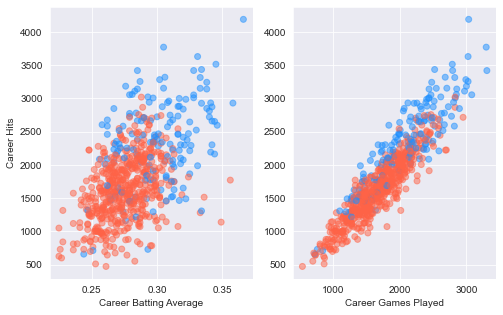

In [2]:
#scatter plot of hits and homeruns
import seaborn as sns

sns.set_style('darkgrid')
ba_array = np.array(hof_batting['BA'])
hits_array = np.array(hof_batting['H'])
gp_array = np.array(hof_batting['G'])
colors = {0: 'tomato', 1: 'dodgerblue'}
plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.scatter(ba_array, hits_array, c=hof_batting['inductedbin'].map(colors), alpha=0.5)
#plt.title('Career Hits and Avg, grouped by Induction Status')
plt.ylabel('Career Hits')
plt.xlabel('Career Batting Average')

plt.subplot(1, 2, 2)
plt.scatter(gp_array, hits_array, c=hof_batting['inductedbin'].map(colors), alpha=0.5)
#plt.title('Career Batting Statistics, grouped by Induction Status')
plt.xlabel('Career Games Played')
plt.subplots_adjust(hspace = 10)
plt.show()

# The Logistic Regression Model

### Model Design
Since this project centers around a binary dependent variable (either the player gets into the hall or doesn't), we will begin with a binomial logistic regression model. First, arrays were created for the independent and dependent variables. The formula for the fitted regression line will therefore be: 

$$ \ell = \beta_0 + \beta_1 G + \beta_2 AB + \beta_3 H + \beta_4 HR + \beta_5 BA $$

where $ \ell $ is the log-odds expression $ log(\frac{p}{1 - p}) $ 

### Preparing and Fitting the Model
Then, using Scikit-Learn's _train_test_split_ module, the data was separated into training and test sets, at an 80-20 ratio of training to test. Given that there are wide variances in the scale of the variables (ie 3000 hits vs 0.300 batting average), the data is normalized to center at 0 using the slkearn module _StandardScaler_. Finally, the log regression model is created using  the _LogisticRegression_ module and then fit to the data.

In [3]:
#log regression of batting variables on hall of fame entry
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

#creating datapoints for the dependent and independent variables:
features = hof_batting[['G', 'AB', 'H', 'HR', 'BA']]
result = hof_batting[['inductedbin']]

#splitting the data into training and test splits:
x_train, x_test, y_train, y_test = train_test_split(features, result, train_size=0.8, random_state=1)

#creating and fitting a scaler model such that the data has mean=0 and standard dev=1:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#creating and training the log regression model:
model = LogisticRegression()
model.fit(x_train, y_train.values.ravel())

#model score:
train_score = model.score(x_train, y_train)
#y_predict = model.predict(x_test)
#r2 = r2_score(y_test, y_predict)
print(train_score)
#print(r2)

#coefficients:
coefficients = model.coef_
print(coefficients)

0.8598484848484849
[[-0.55841045  0.90135726  0.7575533   0.16984095  1.19141738]]


The model coefficients break down as follows:

|      | 'G'     | 'AB'   | 'H'    | 'HR'   | 'BA'   |
|------|---------|--------|--------|--------|--------|
| coef | -0.5584 | 0.9013 | 0.7576 | 0.1698 | 1.1914 |

The accuracy of the model is about 86%, which is surprisingly good overall given the relatively few dependent variables used (in the context of baseball) and the limitations of the dataset. __At Bats__, __Hits__, and __Batting Average__ are the most significant contributors. __Home runs__ have less of an impact than was initially expected; this is likely because of players who played in pre-1930's MLB, where home runs were less common. Also surprising is the negative coefficient of __Games Played__; this could be in part because, on its own, playing many games does not inherently mean a player is hall of fame-caliber, though I suspect this may be caused by outliers. 

The magnitude of these coefficients, and thus their impact on the player's success probability, are visualized in the chart below. 

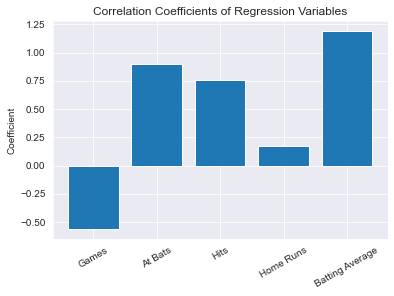

In [4]:
#visualization of model coefficients
x = range(5)
y = [-0.5584, 0.9013, 0.7576, 0.1698, 1.1914]
graphlabels = ['Games', 'At Bats', 'Hits', 'Home Runs', 'Batting Average']
ax = plt.subplot()
plt.bar(x, y)
plt.ylabel('Coefficient')
plt.title('Correlation Coefficients of Regression Variables')
ax.set_xticks(range(len(graphlabels)))
ax.set_xticklabels(graphlabels, rotation=30)
plt.show()


# Model Testing
In the next cell the log regression model is tested with new datapoints that are not in the original dataset. Both are players who have appeared on recent HOF ballots. Derek Jeter was inducted in his first year of eligibility in 2020, while Michael Cuddyer is likely to be rejected in his first year (2021).

|      Player     |   G   |   AB   |   H   |  HR |  BA  |
|:---------------:|:-----:|:------:|:-----:|:---:|:----:|
| Derek Jeter     | 2,747 | 11,195 | 3,465 | 260 | .310 |
| Michael Cuddyer | 1,536 | 5,488  | 1,522 | 197 | .277 |

Jeter has significantly better career stats than Cuddyer and as such the model is expected to predict that Jeter has a higher probability of entering the Hall. The model performs as expected, predicting that Jeter enters the Hall with an acceptance probability of 95%, while Cuddyer does not make it in, with a 93% probability of being rejected.

In [5]:
#testing model predictions with new datapoints:
derek_jeter = [2747, 11195, 3465, 260, 0.310]
michael_cuddyer = [1536, 5488, 1522, 197, 0.277]

sample_players = np.array([derek_jeter, michael_cuddyer])
sample_players = scaler.transform(sample_players)
print(sample_players)

print(model.predict(sample_players))
print(model.predict_proba(sample_players))

[[ 2.06892341  2.64935383  2.83453098  0.73911161  1.23858543]
 [-0.46524421 -0.42871452 -0.43634215  0.26609838 -0.17777688]]
[1 0]
[[0.04528162 0.95471838]
 [0.92800863 0.07199137]]


# The Decision Tree
The following cell contains a Decision Tree model which was fit and trained on the same data as the linear regression model from before. The sample datapoints used to test the previous model were again applied here and the same conclusions were reached. However, the Decision Tree has a lower accuracy score, at roughly 77% in its first iteration. This is likely due to some of the limitations of the Decision Tree model, and will be improved with further optimizations in the next step.

In [6]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#making the decision tree model:
clf = DecisionTreeClassifier(random_state=1, max_depth=5)
clf.fit(x_train, y_train)
tree_score = clf.score(x_test, y_test)

#model score:
print(tree_score)

#testing model predictions with same datapoints as before:
print(clf.predict(sample_players))

0.8195488721804511
[1 0]


## Diagnostics and Model Optimization
In the cell below, a diagnostic test is run on the decision tree model. An inital visualization of the tree revealed that it was likely suffering from over-complexity and overfitting. As expected, pruning is required to improve the model's efficiency. Below, a function is employed to demonstrate the ideal depth of the Tree. We can see that the model achieves its peak accuracy at a maximum depth of 5. After making the adjustments to the original model above, its accuracy score improved to roughly 82%, with maximum depth set to 5.

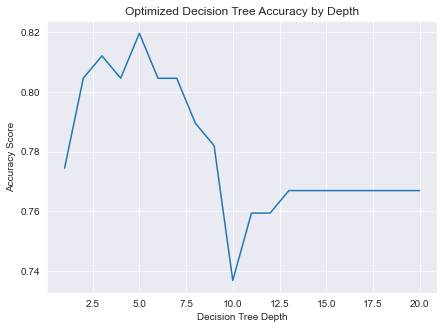

In [7]:
#decision tree pruning
scores = []
for i in range(1, 21):
    tree1 = DecisionTreeClassifier(random_state=1, max_depth = i)
    tree1.fit(x_train, y_train)
    score = tree1.score(x_test, y_test)
    scores.append(score)

#visualization of the pruning process
graph_x = range(1, 21)
plt.figure(figsize=(7, 5))
plt.plot(graph_x, scores)
plt.xlabel('Decision Tree Depth')
plt.ylabel('Accuracy Score')
plt.title('Optimized Decision Tree Accuracy by Depth')
plt.show()

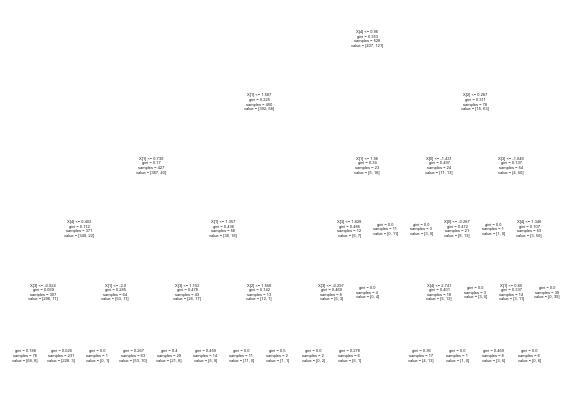

In [8]:
#Decision Tree visualization:

from sklearn.tree import plot_tree
plt.figure(figsize=(10, 7))
plot_tree(clf)
plt.show()

# Decision Tree Test on Real-World Data

To analyze the functionality of the Decision Tree designed in the previous steps, it was fed the career batting data of all hitters who appear on the 2021 Hall of Fame ballot (15 in total). The data was obtained from Baseball Reference (https://www.baseball-reference.com/awards/hof_2021.shtml) since Bonds was the only player from the group to be listed in the _hof_batting_ dataframe. Of the 15 players provided to the model, 6 were selected as probable Hall of Famers, and their names are printed below. 

In [11]:
#2021 Hall of Fame ballot players' stats:
ballot_21 = [[2986, 9847, 2935, 762, 0.298], [2968, 10586, 2877, 80, 0.272], [2576, 9217, 2689, 509, 0.292],
             [2302, 8244, 2574, 555, 0.312], [2247, 7962, 2519, 369, 0.316], [2425, 8480, 2470, 288, 0.291], 
             [2298, 8498, 2461, 377, 0.290], [2372, 8857, 2452, 353, 0.277], [2354, 8813, 2408, 609, 0.273], 
             [2194, 8136, 2303, 386, 0.283], [2308, 7398, 2077, 316, 0.281], [2196, 7599, 1933, 434, 0.254], 
             [1536, 5488, 1522, 197, 0.277], [1527, 5369, 1338, 245, 0.249], [1299, 4630, 1274, 108, 0.275]]

#2021 Hall of Fame players:
ballot_players = ['Barry Bonds', 'Omar Vizquel', 'Gary Sheffield', 'Manny Ramirez', 'Todd Helton', 'Bobby Abreu',
                 'Jeff Kent', 'Torii Hunter', 'Sammy Sosa', 'Aramis Ramirez', 'Scott Rolen', 'Andruw Jones', 
                 'Michael Cuddyer', 'Nick Swisher', 'Shane Victorino']

#preparing the data and making predictions with the new data:
ballot_21 = scaler.transform(ballot_21)
tree_predictions = clf.predict(ballot_21)
print(tree_predictions)

#using a formula to make the model results slightly more interpretable:

def inductions(ballot_players, tree_predictions):
    inducted = []
    not_inducted = []
    for i in range(len(ballot_players)):
        player = ballot_players[i]
        if tree_predictions[i] == 1:
            inducted.append(player)
        elif tree_predictions[i] == 0:
            not_inducted.append(player)
    return inducted, not_inducted

tree_inductions, tree_passes = inductions(ballot_players, tree_predictions)

print(tree_inductions)

[1 1 0 1 1 0 1 0 0 1 0 0 0 0 0]
['Barry Bonds', 'Omar Vizquel', 'Manny Ramirez', 'Todd Helton', 'Jeff Kent', 'Aramis Ramirez']


## Log model test

The same 2021 data was fed into the log regression model used earlier, in order to compare the predictions of the 2 models and see if anything can be learned about their selection process from the differences in their picks.

In [13]:
log_predictions_21 = model.predict(ballot_21)
print(log_predictions_21)

linear_inductions, linear_passes = inductions(ballot_players, log_predictions_21)
print(linear_inductions)

[1 0 1 1 1 0 1 0 0 0 0 0 0 0 0]
['Barry Bonds', 'Gary Sheffield', 'Manny Ramirez', 'Todd Helton', 'Jeff Kent']


# Observations and Conclusion

This project was intended as an interest-based application of various data analytic and machine learning skills. My main focus for the project was to gain practice and experience cleaning and organizing data, building and testing analytical models, and applying some statistical theory. As such, the results of this project are not intended to be an extensively accurate prediction of which players will be inducted into the MLB Hall of Fame, though I did try to be as thorough as possible. However, there are already [advanced sabermetric models](https://www.baseball-reference.com/about/leader_glossary.shtml#hof_monitor) which are designed to predict hall-of-fame inductees much more accurately.

From the two tests conducted above, we can see that the log regression model was more discerning, with only 5 predicted inductees to the decision tree's 6. Bonds, Manny Ramirez, Todd Helton, and Jeff Kent were selected by both models. Given that we already know the coefficients of the log model, its predictions make sense, given that it selected the players with the highest batting averages, most at bats, and most hits. Despite having over 2800 hits (a common threshold for real-life HOF induction), Omar Vizquel was likely punished by the log model's negative coefficient for games played, since his other stats were not strong enough to make up for it. The decision tree's predictions are slightly more unintuitive, with a lower threshold for induction. In particular, Aramis Ramirez's inclusion is a bit of a head-scratcher.

This commentary concludes the project. Overall, the two models constructed here performed well and were surprisingly accurate given their limitations. I would like to revisit this in the future to create a more thorough model with more parameters, and perhaps use a Random Forest or other more advanced predictive model. Some potential weaknesses/corrections that would need to be adressed then include: 
* Adding more independent variables to improve the model's depth and accuracy (these might include more advanced batting stats like OPS or defensive/baserunning stats which were not tracked at all for this project)
* Design a model to predict hall of fame induction for pitchers
